In [0]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os
import os.path as osp
import sys
import time
import cv2
from tqdm import tqdm, tnrange, tqdm_notebook
from collections import OrderedDict
import PIL
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt
import collections
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch import Tensor
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split, Subset

import torchvision
from torchvision import transforms, datasets, models

from mpl_toolkits.axes_grid1 import ImageGrid

In [0]:
CUDA = True
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
weight_path = './yolov3.weights'
coco_path = './coco.names'

## Download weight file, around 300mb

In [0]:
import urllib.request
if not osp.exists(weight_path):
    urllib.request.urlretrieve('https://pjreddie.com/media/files/yolov3.weights', weight_path)  

In [0]:
def load_coco(path):
    with open(path) as f:
        return [line.rstrip("\n") for line in f.readlines()]

In [0]:
classes = load_coco(coco_path)

# Preprocess Image

In [0]:
def letterbox_transforms(inner_dim, outer_dim):
    outer_w, outer_h = outer_dim
    inner_w, inner_h = inner_dim
    ratio = min(outer_w / inner_w, outer_h / inner_h)
    box_w = int(inner_w * ratio)
    box_h = int(inner_h * ratio)
    box_x_offset = (outer_w // 2) - (box_w // 2)
    box_y_offset = (outer_h // 2) - (box_h // 2)
    return box_w, box_h, box_x_offset, box_y_offset, ratio

In [0]:
def letterbox_image(img, dim):
    #Create the background
    image = np.full(dim +(3,), 128)
        
    img_dim = (img.shape[1], img.shape[0])
    box_w, box_h, box_x, box_y, ratio = letterbox_transforms(img_dim, dim)
    box_image = cv2.resize(img, (box_w,box_h), interpolation = cv2.INTER_CUBIC)
        
    #Put the box image on top of the blank image
    image[box_y:box_y+box_h, box_x:box_x+box_w] = box_image
        
    return image, (box_w, box_h, box_x, box_y, ratio)

In [0]:
# Mode - letterbox, resize
def load_image(img_path, mode=None, dim=None):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    trans = None
    if mode is not None and dim is not None:
        if mode == 'letterbox':
            img, trans = letterbox_image(img, dim)
        elif mode == 'resize':
            img = cv2.resize(img, dim)
    
    img = torch.from_numpy(img).float().permute(2,0,1) / 255
    return img, trans

# Basic network building blocks - conv_bn_relu, res_layer

In [0]:
class conv_bn_relu(nn.Module):
    def __init__(self, nin, nout, ks, s=1, pad='SAME', padding=0, bn=True, act="leakyRelu"):
        super().__init__()
        
        self.bn = bn
        self.act = act
                
        if pad == 'SAME':
            padding = (ks - 1) // 2
            
        self.conv = nn.Conv2d(nin, nout, ks, s, padding, bias=not bn)
        if bn == True:
            self.bn = nn.BatchNorm2d(nout)
        if act == "leakyRelu":
            self.relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))
    
class res_layer(nn.Module):
    def __init__(self, nin):
        super().__init__()
        self.conv1 = conv_bn_relu(nin, nin//2, ks=1)
        self.conv2 = conv_bn_relu(nin//2, nin, ks=3)
        
    def forward(self, x):
        return x + self.conv2(self.conv1(x))

# Map2cfgDict - used  to creating mapping that follows the cfg file from prjreddit's repository

In [0]:
def map2cfgDict(mlist):
    idx = 0
    mdict = OrderedDict()
    for i,m in enumerate(mlist):
        if isinstance(m, res_layer):
            mdict[idx] = None
            mdict[idx+1] = None
            idx += 2
        mdict[idx] = i
        idx += 1
    return mdict

# Darknet53 - Feature extraction

In [0]:
def make_res_stack(nin, num_blk):
    return nn.ModuleList([conv_bn_relu(nin, nin*2, 3, s=2)] \
           + [res_layer(nin*2) for n in range(num_blk)])

class Darknet(nn.Module):
    def __init__(self, blkList, nout=32):
        super().__init__()
        self.mlist = nn.ModuleList()
        self.mlist += [conv_bn_relu(3, nout, 3)]
        for i,nb in enumerate(blkList):
            self.mlist += make_res_stack(nout*(2**i), nb)
            
        self.map2yolocfg = map2cfgDict(self.mlist)
        self.cachedOutDict = dict()
        
    def forward(self,x):
        for i,m in enumerate(self.mlist):
            x = m(x)
            if i in self.cachedOutDict:
                self.cachedOutDict[i] = x
        return x
    
    #mode - normal  -- direct index to mlist
    #     - yolocfg -- index follow the sequences of the cfg file from https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg
    def addCachedOut(self, idx, mode="yolocfg"):
        if mode == "yolocfg":
            idxs = self.map2yolocfg[idx]
        self.cachedOutDict[idxs] = None
        
    def getCachedOut(self, idx, mode="yolocfg"):
        if mode == "yolocfg":
            idxs = self.map2yolocfg[idx]
        return self.cachedOutDict[idxs]

# PreDetectionConvGroup - conv layers before the yolo detection layer

In [0]:
class PreDetectionConvGroup(nn.Module):
    def __init__(self, nin, nout, num_conv=3, numClass=80):
        super().__init__()
        self.mlist = nn.ModuleList()
        
        for i in range(num_conv):
            self.mlist += [conv_bn_relu(nin, nout, ks=1)]
            self.mlist += [conv_bn_relu(nout, nout*2, ks=3)]
            if i == 0:
                nin = nout*2
                
        self.mlist += [nn.Conv2d(nin, (numClass+5)*3, 1)]
        self.map2yolocfg = map2cfgDict(self.mlist)
        self.cachedOutDict = dict()
        
    def forward(self,x):
        for i,m in enumerate(self.mlist):
            x = m(x)
            if i in self.cachedOutDict:
                self.cachedOutDict[i] = x
        return x
    
    #mode - normal  -- direct index to mlist 
    #     - yolocfg -- index follow the sequences of the cfg file from https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg
    def addCachedOut(self, idx, mode="yolocfg"):
        if mode == "yolocfg":
            idx = self.getIdxFromYoloIdx(idx)
        elif idx < 0:
            idx = len(self.mlist) - idx
        
        self.cachedOutDict[idx] = None
        
    def getCachedOut(self, idx, mode="yolocfg"):
        if mode == "yolocfg":
            idx = self.getIdxFromYoloIdx(idx)
        elif idx < 0:
            idx = len(self.mlist) - idx
        return self.cachedOutDict[idx]
    
    def getIdxFromYoloIdx(self,idx):
        if idx < 0:
            return len(self.map2yolocfg) + idx
        else:
            return self.map2yolocfg[idx]

# UpsampleGroup - grab feature maps from early high resolution layers and concatenate it with upsampled feature maps

In [0]:
class UpsampleGroup(nn.Module):
    def __init__(self, nin):
        super().__init__()
        self.conv = conv_bn_relu(nin, nin//2, ks=1)
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        
    def forward(self, route_head, route_tail):
        out = self.up(self.conv(route_head))
        return torch.cat((out, route_tail), 1)

# Yolo Detection Layer

In [0]:
class YoloLayer(nn.Module):
    def __init__(self, anchors, img_dim, numClass):
        super().__init__()
        self.anchors = anchors
        self.img_dim = img_dim
                
        self.numClass = numClass
        self.bbox_attrib = 5 + numClass
        
    def forward(self, x, img_dim):
        #x : bs x nA*(5 + num_classes) * h * w
        nB = x.shape[0]
        nA = len(self.anchors)
        nH, nW = x.shape[2], x.shape[3]
        stride = img_dim[1] / nH
        anchors = torch.FloatTensor(self.anchors) / stride
        
        #Reshape predictions from [B x [A * (5 + numClass)] x H x W] to [B x A x H x W x (5 + numClass)]
        preds = x.view(nB, nA, self.bbox_attrib, nH, nW).permute(0, 1, 3, 4, 2).contiguous()
        
        # tx, ty, tw, wh
        preds_xy = preds[..., :2]
        preds_wh = preds[..., 2:4]
        preds_conf = preds[..., 4].sigmoid()
        preds_cls = preds[..., 5:].sigmoid()
        
        # Calculate cx, cy, anchor mesh
        mesh_x = torch.arange(nW).repeat(nH,1).unsqueeze(2)
        mesh_y = torch.arange(nH).repeat(nW,1).t().unsqueeze(2)
        mesh_xy = torch.cat((mesh_x,mesh_y), 2)
        mesh_anchors = anchors.view(1, nA, 1, 1, 2).repeat(1, 1, nH, nW, 1)
        
        # pred_boxes holds bx,by,bw,bh
        pred_boxes = torch.FloatTensor(preds[..., :4].shape)
        pred_boxes[..., :2] = preds_xy.detach().cpu().sigmoid() + mesh_xy # sig(tx) + cx
        pred_boxes[..., 2:4] = preds_wh.detach().cpu().exp() * mesh_anchors  # exp(tw) * anchor
        
        # Return predictions if not training 
        out = torch.cat((pred_boxes.cuda() * stride, 
                         preds_conf.cuda().unsqueeze(4),
                         preds_cls.cuda() ), 4)
        
        # Reshape predictions from [B x A x H x W x (5 + numClass)] to [B x [A x H x W] x (5 + numClass)]
        # such that predictions at different strides could be concatenated on the same dimension
        out = out.permute(0, 2, 3, 1, 4).contiguous().view(nB, nA*nH*nW, self.bbox_attrib)
       
        return out

# Entire network - putting everything together

In [0]:
class YoloNet(nn.Module):
    def __init__(self, img_dim=None, anchors = [10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326], numClass=80):
        super().__init__()
        nin = 32
        self.numClass = numClass
        self.img_dim = img_dim
        self.stat_keys = ['loss', 'loss_x', 'loss_y', 'loss_w', 'loss_h', 'loss_conf', 'loss_cls',
                          'nCorrect', 'nGT', 'recall']
        
        anchors = [(anchors[i], anchors[i+1]) for i in range(0,len(anchors),2)]
        anchors = [anchors[i:i+3] for i in range(0, len(anchors), 3)][::-1]
                
        self.feature = Darknet([1,2,8,8,4])
        self.feature.addCachedOut(61)
        self.feature.addCachedOut(36)
        
        self.pre_det1 = PreDetectionConvGroup(1024, 512, numClass=self.numClass)
        self.yolo1 = YoloLayer(anchors[0], img_dim, self.numClass)
        self.pre_det1.addCachedOut(-3) #Fetch output from 4th layer backward including yolo layer
        
        self.up1 = UpsampleGroup(512)
        self.pre_det2 = PreDetectionConvGroup(768, 256, numClass=self.numClass)
        self.yolo2 = YoloLayer(anchors[1], img_dim, self.numClass)
        self.pre_det2.addCachedOut(-3)
        
        self.up2 = UpsampleGroup(256)
        self.pre_det3 = PreDetectionConvGroup(384, 128, numClass=self.numClass)
        self.yolo3 = YoloLayer(anchors[2], img_dim, self.numClass)
        
   
    def forward(self, x):
        img_dim = (x.shape[3], x.shape[2])
        #Extract features
        out = self.feature(x)
                
        #Detection layer 1
        out = self.pre_det1(out)
        det1 = self.yolo1(out, img_dim)
        
        #Upsample 1
        r_head1 = self.pre_det1.getCachedOut(-3)
        r_tail1 = self.feature.getCachedOut(61)
        out = self.up1(r_head1,r_tail1)
                
        #Detection layer 2
        out = self.pre_det2(out)
        det2 = self.yolo2(out, img_dim)
        
        #Upsample 2
        r_head2 = self.pre_det2.getCachedOut(-3)
        r_tail2 = self.feature.getCachedOut(36)
        out = self.up2(r_head2,r_tail2)
                
        #Detection layer 3
        out = self.pre_det3(out)
        det3 = self.yolo3(out, img_dim)
        
        return det1, det2, det3
    
    # Format : pytorch / darknet
    def saveWeight(self, weights_path, format='pytorch'):
        if format == 'pytorch':
            torch.save(self.state_dict(), weights_path)
        elif format == 'darknet':
            raise NotImplementedError
    
    def loadWeight(self, weights_path, format='pytorch'):
        if format == 'pytorch':
            weights = torch.load(weights_path, map_location=lambda storage, loc: storage)
            self.load_state_dict(weights)
        elif format == 'darknet':
            wm = WeightManager(self)
            wm.loadWeight(weights_path)

# WeightManager - load weight file from official Yolo site

In [0]:
class WeightManager:
    def __init__(self, model):
        super().__init__()
        self.conv_list = self.find_conv_layers(model)

    def loadWeight(self, weight_path):
        ptr = 0
        weights = self.read_file(weight_path)
        #print(len(weights))
        for m in self.conv_list:
            if type(m) == conv_bn_relu:
                ptr = self.load_conv_bn_relu(m, weights, ptr)
            elif type(m) == nn.Conv2d:
                ptr = self.load_conv2D(m, weights, ptr)
        return ptr
                
    def read_file(self, file):
        with open(file, "rb") as fp:
            header = np.fromfile(fp, dtype = np.int32, count = 5)
            self.header = torch.from_numpy(header)
            self.seen = self.header[3]
            weights = np.fromfile(fp, dtype = np.float32)
        return weights
    
    def copy_weight_to_model_parameters(self, param, weights, ptr):
        num_el = param.numel()
        param.data.copy_(torch.from_numpy(weights[ptr:ptr + num_el])
                             .view_as(param.data))
        return ptr + num_el
    
    def load_conv_bn_relu(self, m, weights, ptr):
        ptr = self.copy_weight_to_model_parameters(m.bn.bias, weights, ptr)
        ptr = self.copy_weight_to_model_parameters(m.bn.weight, weights, ptr)
        ptr = self.copy_weight_to_model_parameters(m.bn.running_mean, weights, ptr)
        ptr = self.copy_weight_to_model_parameters(m.bn.running_var, weights, ptr)
        ptr = self.copy_weight_to_model_parameters(m.conv.weight, weights, ptr)
        return ptr
        
    def load_conv2D(self, m, weights, ptr):
        ptr = self.copy_weight_to_model_parameters(m.bias, weights, ptr)
        ptr = self.copy_weight_to_model_parameters(m.weight, weights, ptr)
        return ptr
        
    def find_conv_layers(self, mod):
        module_list = []
        for m in mod.children():
            if type(m) == conv_bn_relu:
                module_list += [m]
            elif type(m) == nn.Conv2d:
                module_list += [m]
            elif isinstance(m, (nn.ModuleList, nn.Module)):
                module_list += self.find_conv_layers(m)
            elif type(m) == res_layer:
                module_list += self.find_conv_layers(m)
        return module_list

In [0]:
net = YoloNet().to(device).eval()
net.loadWeight(weight_path, format='darknet')

In [0]:
imglist = os.listdir('imgs')
for i,img in enumerate(imglist):
    print('{}: {}'.format(i,img))

0: dog.jpg
1: scream.jpg
2: img3.jpg
3: eddy.jpeg
4: eagle.jpg
5: person.jpg
6: ny_street.jpeg
7: hk_traffic_1.jpeg
8: 034_Felice_Herrig_vs_Cortney_Casey.0.jpg
9: london.png
10: nick.jpeg
11: cup1.jpg
12: hk_traffic.jpeg
13: edwin.jpeg
14: two_asian.jpeg
15: giraffe.jpg
16: img4.jpg
17: exvsmbon.jpg
18: img1.jpg
19: img2.jpg
20: dog-cycle-car.png
21: messi.jpg
22: herd_of_horses.jpg


In [0]:
img_path = f"imgs/{imglist[0]}"
resolution = 416
testData, trans = load_image(img_path, mode='letterbox', dim=(resolution, resolution))
testData = testData.unsqueeze(0).to(device)
det1,det2,det3 = net(testData)

det1.shape,det2.shape,det3.shape

(torch.Size([1, 507, 85]),
 torch.Size([1, 2028, 85]),
 torch.Size([1, 8112, 85]))

# Helper functions to find unique values in tensor

In [0]:
def torch_unique(inp, CUDA=True):
    if CUDA:
        inp_cpu = inp.detach().cpu()
    
    res_cpu = torch.unique(inp_cpu)
    res = inp.new(res_cpu.shape)
    res.copy_(res_cpu)
    
    return res

In [0]:
def unqiue_with_order(inp, CUDA=True):
    if CUDA:
        inp_np = inp.detach().cpu().numpy()
    
    _, idx = np.unique(inp, return_index=True)
    result = inp_np[np.sort(idx)]
    result_tensor = torch.from_numpy(result)
    res = inp.new(result_tensor.shape)
    res.copy_(result_tensor)
    return res


# IOU and non-max supression(NMS)

In [0]:
def iou_vectorized(bbox):
    num_box = bbox.shape[0]
    
    bbox_leftTop_x =  bbox[:,0]
    bbox_leftTop_y =  bbox[:,1]
    bbox_rightBottom_x = bbox[:,2]
    bbox_rightBottom_y = bbox[:,3]
    
    inter_leftTop_x     =  torch.max(bbox_leftTop_x.unsqueeze(1).repeat(1,num_box), bbox_leftTop_x)
    inter_leftTop_y     =  torch.max(bbox_leftTop_y.unsqueeze(1).repeat(1,num_box), bbox_leftTop_y)
    inter_rightBottom_x =  torch.min(bbox_rightBottom_x.unsqueeze(1).repeat(1,num_box), bbox_rightBottom_x)
    inter_rightBottom_y =  torch.min(bbox_rightBottom_y.unsqueeze(1).repeat(1,num_box), bbox_rightBottom_y)
    
    inter_area = torch.clamp(inter_rightBottom_x - inter_leftTop_x, min=0) * torch.clamp(inter_rightBottom_y - inter_leftTop_y, min=0)
    bbox_area = (bbox_rightBottom_x - bbox_leftTop_x) * (bbox_rightBottom_y - bbox_leftTop_y)
    union_area = bbox_area.expand(num_box,-1) + bbox_area.expand(num_box,-1).transpose(0, 1) - inter_area
    
    iou = inter_area / union_area
    return iou

#Iterate through the bounding boxes and remove rows accordingly
def reduce_row_by_column(inp):
    i = 0
    while i < inp.shape[0]:
        remove_row_idx = inp[i][1].item()
        if inp[i][0] != remove_row_idx and i < inp.shape[0]:
            keep_mask = (inp[:,0] != remove_row_idx).nonzero().squeeze()
            inp = inp[keep_mask]
        i += 1
    return inp

#bbox is expected to be sorted by class score in descending order
def nms(bbox, iou, nms_thres):
    #Create a mapping that indicates which row has iou > threshold
    remove_map = (iou > nms_thres).nonzero()
    remove_map = reduce_row_by_column(remove_map)
    
    remove_idx = torch_unique(remove_map[:,0])
    res_bbox = bbox[remove_idx]
    
    return res_bbox

# Post-processing - convert predictions from network to bounding boxes (calls IOU/NMS)

In [0]:
def postprocessing(detections, num_classes, obj_conf_thr=0.5, nms_thr=0.4):
    #Zero bounding box with objectioness confidence score less than threshold 
    obj_conf_filter = (detections[:,:,4] > obj_conf_thr).float().unsqueeze(2)
    detections = detections * obj_conf_filter
           
    #Transform bounding box coordinates to two corners
    box = detections.new(detections[:,:,:4].shape)
    box[:,:,0] = detections[:,:,0] - detections[:,:,2]/2
    box[:,:,1] = detections[:,:,1] - detections[:,:,3]/2
    box[:,:,2] = box[:,:,0] + detections[:,:,2]
    box[:,:,3] = box[:,:,1] + detections[:,:,3]
    detections[:,:,:4] = box
    
    num_batches = detections.shape[0]
    #results = torch.Tensor().to(device)
    results = list()
        
    for b in range(num_batches):
        batch_results = torch.Tensor().cuda()
        img_det = detections[b]
        	
        
        max_class_score, max_class_idx= torch.max(img_det[:,5:5 + num_classes], 1)
        img_det = torch.cat((img_det[:,:5],
                             max_class_score.float().unsqueeze(1),
                             max_class_idx.float().unsqueeze(1)
                            ), 1)
        #img det - [b1_x, b1_y, b2_x, b2_y, obj_conf, class_score, class]
        
        #Remove zeroed rows
        nonzero_idx =  img_det[:,4].nonzero()
        img_det = img_det[nonzero_idx,:].view(-1,7)
               
        if img_det.shape[0] == 0:
            results.append(batch_results.cpu())
        else:
            #Get the classes
            img_classes = torch_unique(img_det[:,-1])
            for c in img_classes:
                # Select rows with "c" class and sort by the class score
                class_img_det = img_det[(img_det[:,-1] == c).nonzero().squeeze()]
                # If there is only one detection, it will return a 1D tensor. Therefore, we perform a view to keep it in 2D
                class_img_det = class_img_det.view(-1, 7)
                #Sort by objectness score
                _, sort_idx = class_img_det[:,4].sort(descending=True)
                class_img_det = class_img_det[sort_idx]

                iou = iou_vectorized(class_img_det)
                #Alert: There's another loop operation in nms function
                class_img_det = nms(class_img_det, iou, nms_thr)
                batch_results = torch.cat((batch_results, class_img_det), 0)

            results.append(batch_results.cpu())
    
    return results

In [0]:
detections = torch.cat((det1,det2,det3), 1)
pdet = postprocessing(detections, 80, obj_conf_thr=0.5)
detections.shape, pdet[0]

(torch.Size([1, 10647, 85]),
 tensor([[  69.5402,  173.2032,  170.3746,  343.0714,    0.9997,    0.9885,
            16.0000],
         [  89.2842,  110.7768,  303.7395,  294.2656,    0.9952,    0.9997,
             1.0000],
         [ 256.4959,   98.3481,  373.2535,  144.1314,    0.9953,    0.9430,
             7.0000]]))

In [0]:
print(pdet[0].shape)
pdet

torch.Size([3, 7])


[tensor([[  69.5402,  173.2032,  170.3746,  343.0714,    0.9997,    0.9885,
            16.0000],
         [  89.2842,  110.7768,  303.7395,  294.2656,    0.9952,    0.9997,
             1.0000],
         [ 256.4959,   98.3481,  373.2535,  144.1314,    0.9953,    0.9430,
             7.0000]])]

# Draw image and predictions

In [0]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [0]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [0]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=0.5))
    draw_outline(patch, 2)

In [0]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [0]:
def bbox_plt(box):
    bx, by = box[0], box[1]
    bw = box[2] - box[0]
    bh = box[3] - box[1]
    return [bx, by, bw, bh]

In [0]:
def show_output(img, dets):
    ax = show_img(img, figsize=(16,8))
    for d in dets:
        draw_rect(ax, bbox_plt(d))
        c = classes[d[-1].int().item()]
        draw_text(ax, d[:2], c)

## Show predictions with the image processed by the network (letterboxed image)

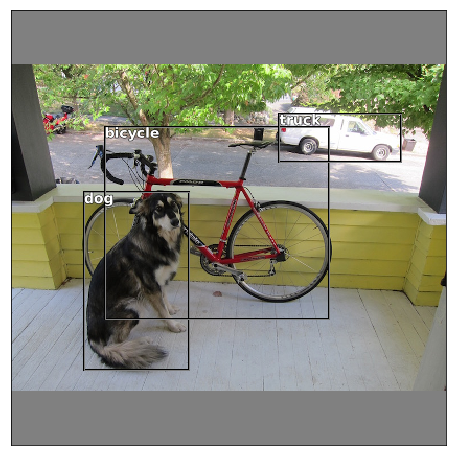

In [0]:
show_output(testData.squeeze(0).permute(1,2,0), pdet[0])

## Transform bounding boxes to fit the original image's dimension

In [0]:
#load the original image with no letterbox
img, _ = load_image(f"imgs/{imglist[0]}")
img = img.permute(1,2,0)

In [0]:
def bbox_transform(box, x_max, y_max, x_offset, y_offset, ratio):
    box[:,[0,2]] = torch.clamp((box[:,[0,2]] - x_offset) / ratio, 0, x_max)
    box[:,[1,3]] = torch.clamp((box[:,[1,3]] - y_offset) / ratio, 0, y_max)
    return box

In [0]:
#trans is returned from the load_image call when we first input the letterboxed image into the network
box = pdet[0][:, :4]
box = bbox_transform(box, img.shape[1], img.shape[0], *trans[-3:])
box

tensor([[ 128.3819,  223.7597,  314.5377,  537.3625],
        [ 164.8324,  108.5111,  560.7498,  447.2596],
        [ 473.5309,   85.5657,  689.0833,  170.0887]])

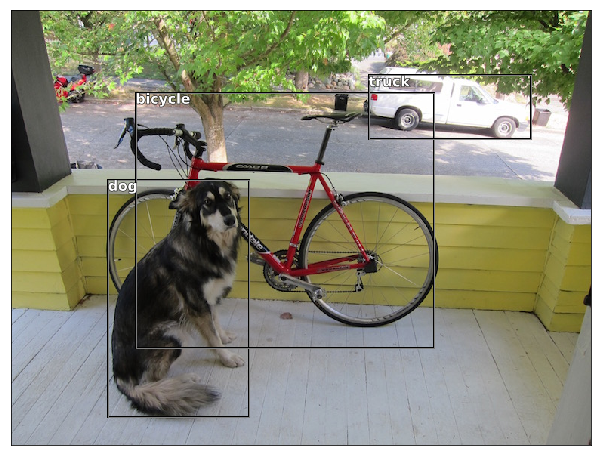

In [0]:
show_output(img, pdet[0])

## Process batches of images from a folder

In [0]:
class ImageFolderDataset(Dataset):
    def __init__(self, img_dir, transforms=None):
        self.img_dir = img_dir
        self.transforms = transforms
        
        self.img_list = os.listdir(img_dir)
        
    def __getitem__(self, idx):
        img_path = osp.join(self.img_dir, self.img_list[idx])
        if osp.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), img_path)
            
        org_img = img.copy()        
        
        img, lb_params = letterbox_image(img, dim)
        img = torch.from_numpy(img).float().permute(2,0,1) / 255
        org_img = torch.from_numpy(org_img).float().permute(2,0,1) / 255
        lb_params = torch.Tensor(lb_params).float()
        
        sample = { 'img': img, 'org_img': org_img, 'lb_params':lb_params }    
        return sample
    
    def __len__(self):
        return len(self.img_list)

In [0]:
bs = 4
sz = 416
dim = (sz, sz)

nImgShow  = 4
start_idx = 0
end_idx = start_idx + nImgShow
dataset_subset_idx = np.arange(start_idx, end_idx)

In [0]:
img_dataset = ImageFolderDataset('./imgs', trans)
img_dataset = Subset(img_dataset, dataset_subset_idx)

# variable_shape_collate_fn
# It's a function responisble for stacking samples into batches.
# By default, it doesn't allow users to output tensors with different shapes.
# "variable_shape_collate_fn" here will collect these tensors into a list if they have inconsistent dimensions
# which is used by 'org_img' since the images will have different width and height before they are letterboxed.
# Try disabling it and it will raise an error in collate_fn. Detail code will be later notebooks.
from dataset import variable_shape_collate_fn

img_dataloader = DataLoader(img_dataset, batch_size=8, collate_fn=variable_shape_collate_fn)

In [0]:
for sample in img_dataloader:
    print(sample['img'].shape)
    print([o.shape for o in sample['org_img']])
    print(sample['lb_params'])

torch.Size([4, 3, 416, 416])
[torch.Size([3, 424, 640]), torch.Size([3, 427, 640]), torch.Size([3, 773, 1200]), torch.Size([3, 800, 1200])]
tensor([[ 416.0000,  275.0000,    0.0000,   71.0000,    0.6500],
        [ 416.0000,  277.0000,    0.0000,   70.0000,    0.6500],
        [ 416.0000,  267.0000,    0.0000,   75.0000,    0.3467],
        [ 416.0000,  277.0000,    0.0000,   70.0000,    0.3467]])


In [0]:
def bbox_relative_to_absolute(box, img_dim, x_idx=[0,2], y_idx=[1,3]):
    box[..., x_idx] *= img_dim[0]
    box[..., y_idx] *= img_dim[1]
    return box

def bbox_x1y1x2y2_to_xywh(box):
    bx, by = box[..., 0], box[..., 1]
    bw = box[..., 2] - box[..., 0]
    bh = box[..., 3] - box[..., 1]
    box[..., 0], box[..., 1], box[..., 2], box[..., 3] = bx, by, bw, bh
    return box

def bbox_transform(box, x_max, y_max, x_offset, y_offset, ratio):
    box[...,[0,2]] = torch.clamp((box[...,[0,2]] - x_offset) / ratio, 0, x_max)
    box[...,[1,3]] = torch.clamp((box[...,[1,3]] - y_offset) / ratio, 0, y_max)
    return box

In [0]:
from boundingbox import BoundingBoxConverter, CoordinateType, FormatType

def fill_label_np_tensor(label, row, col):
    label_tmp = np.full((row, col), 0.0)
    if label is not None and len(label) != 0 :
        length = label.shape[0] if label.shape[0] < row else row
        label_tmp[:length] = label[:length]
    return label_tmp

def prep_img_for_plt(img_list):
    if isinstance(img_list, collections.abc.Sequence):
        img_list = [img.permute(1,2,0).numpy() for img in img_list] 
    else:
        img_list = img_list.permute(0,2,3,1).numpy()
    return img_list

def prep_predictions_for_plt(preds_list, img_list, lb_params_list, reverse_letterbox):
    preds_list = Tensor([fill_label_np_tensor(p.numpy(), 50, 7) for p in preds_list])
    # cls,x1,y1,x2,y2
    preds_list = preds_list[..., [6, 0, 1, 2, 3,]]

    if reverse_letterbox:
        for b_idx, (preds, img, lb_param) in enumerate(zip(preds_list, img_list, lb_params_list)):
            dim = img.shape[1], img.shape[0]
            x_offset, y_offset, ratio = lb_param[-3], lb_param[-2], lb_param[-1]
            for i, prow in enumerate(preds):    
                prow = bbox_transform(prow[1:5], dim[0], dim[1], x_offset, y_offset, ratio)

    preds_list[..., 1:5] =  bbox_x1y1x2y2_to_xywh(preds_list[..., 1:5])
    preds_list = preds_list.numpy()
    
    return preds_list

In [0]:
def predict(data, net, num_classes=80, reverse_letterbox=True):
    img_list = []
    preds_list = []
    lb_params_list = torch.FloatTensor()
    with torch.no_grad(): 
        for sample in data:
            imgs, org_imgs, lb_params = sample['img'].cuda(), sample['org_img'], sample['lb_params']
            dim = (imgs.shape[3], imgs.shape[2])

            lb_params_list = torch.cat((lb_params_list, lb_params), 0)
            # Copy original image instead of the letterboxed image
            if reverse_letterbox:                      
                img_list += [img.cpu() for img in org_imgs]
            else:
                img_list += [img for img in imgs.cpu()]
            
            # Pass images to the network
            det1, det2, det3 = net(imgs)
            predictions = postprocessing(torch.cat((det1,det2,det3), 1), num_classes, obj_conf_thr=0.5, nms_thr=0.4)
            preds_list += predictions

        img_list = prep_img_for_plt(img_list)
        preds_list = prep_predictions_for_plt(preds_list, img_list, lb_params_list, reverse_letterbox)
#         preds_list = prep_predictions_for_plt(preds_list, dim, lb_params_list, reverse_letterbox)
    return img_list, preds_list

In [0]:
img_list, preds_list = predict(img_dataloader, net, reverse_letterbox=False)

In [0]:
print('img_list shape: {}'.format([i.shape for i in img_list]))
print('preds_list shape: {}'.format([p.shape for p in preds_list]))

img_list shape: [(424, 640, 3), (427, 640, 3), (773, 1200, 3), (800, 1200, 3)]
preds_list shape: [(50, 5), (50, 5), (50, 5), (50, 5)]


## Show images in grids

In [0]:
def draw_axis(ax, isDraw=False):
    ax.get_xaxis().set_visible(isDraw)
    ax.get_yaxis().set_visible(isDraw)

def draw_image(ax, img):
    ax.imshow(img, shape=(2,2), aspect='equal')

def draw_labels(ax, labels, classes, coord_idx=[1,2,3,4], class_idx=0):
    for l in labels:
        if l.sum() == 0:
            continue
        rect = l[coord_idx]
        c = classes[l[class_idx].astype(np.int32)]
        draw_rect(ax, rect)
        draw_text(ax, rect[:2], c)
        
# Display a list of images with labels in given grid size         
def show_img_grid(img_list, classes=None,
                  labels_list=None, coord_idx=[1,2,3,4], class_idx=0,
                  cols=2, figsize=None, col_title_dict=None):
    rows = int(np.ceil(len(img_list) / cols))

    heights = [a.shape[0] for a in img_list[::cols]]
    widths = [a.shape[1] for a in img_list[0:cols]]

    fig_width = 25  # inches
    fig_height = fig_width * sum(heights) / sum(widths)
    fig_size = (fig_width, fig_height)

    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=fig_size, gridspec_kw={'height_ratios':heights})
    axes = [ax for ax in axes.ravel()]

    if col_title_dict is not None:
        assert(cols == len(col_title_dict['title']))
        for ax, col in zip(axes[:cols], col_title_dict['title']):
            ax.set_title(col, pad=col_title_dict['pad'], 
                         fontdict={'fontsize': col_title_dict['fontsize'],
                                   'fontweight' : col_title_dict['fontweight'] })
    
    if labels_list is None:
        labels_list = []

    for ax, img, labels in itertools.zip_longest(axes, img_list, labels_list, fillvalue=None):
        if img is not None:
            draw_image(ax, img)
        if labels is not None:
            draw_labels(ax, labels, classes, coord_idx=coord_idx, class_idx=class_idx)
        draw_axis(ax, False)
        
    plt.subplots_adjust(wspace=0.01, hspace=0.02, left=0, right=1, bottom=0, top=1)
    plt.tight_layout()

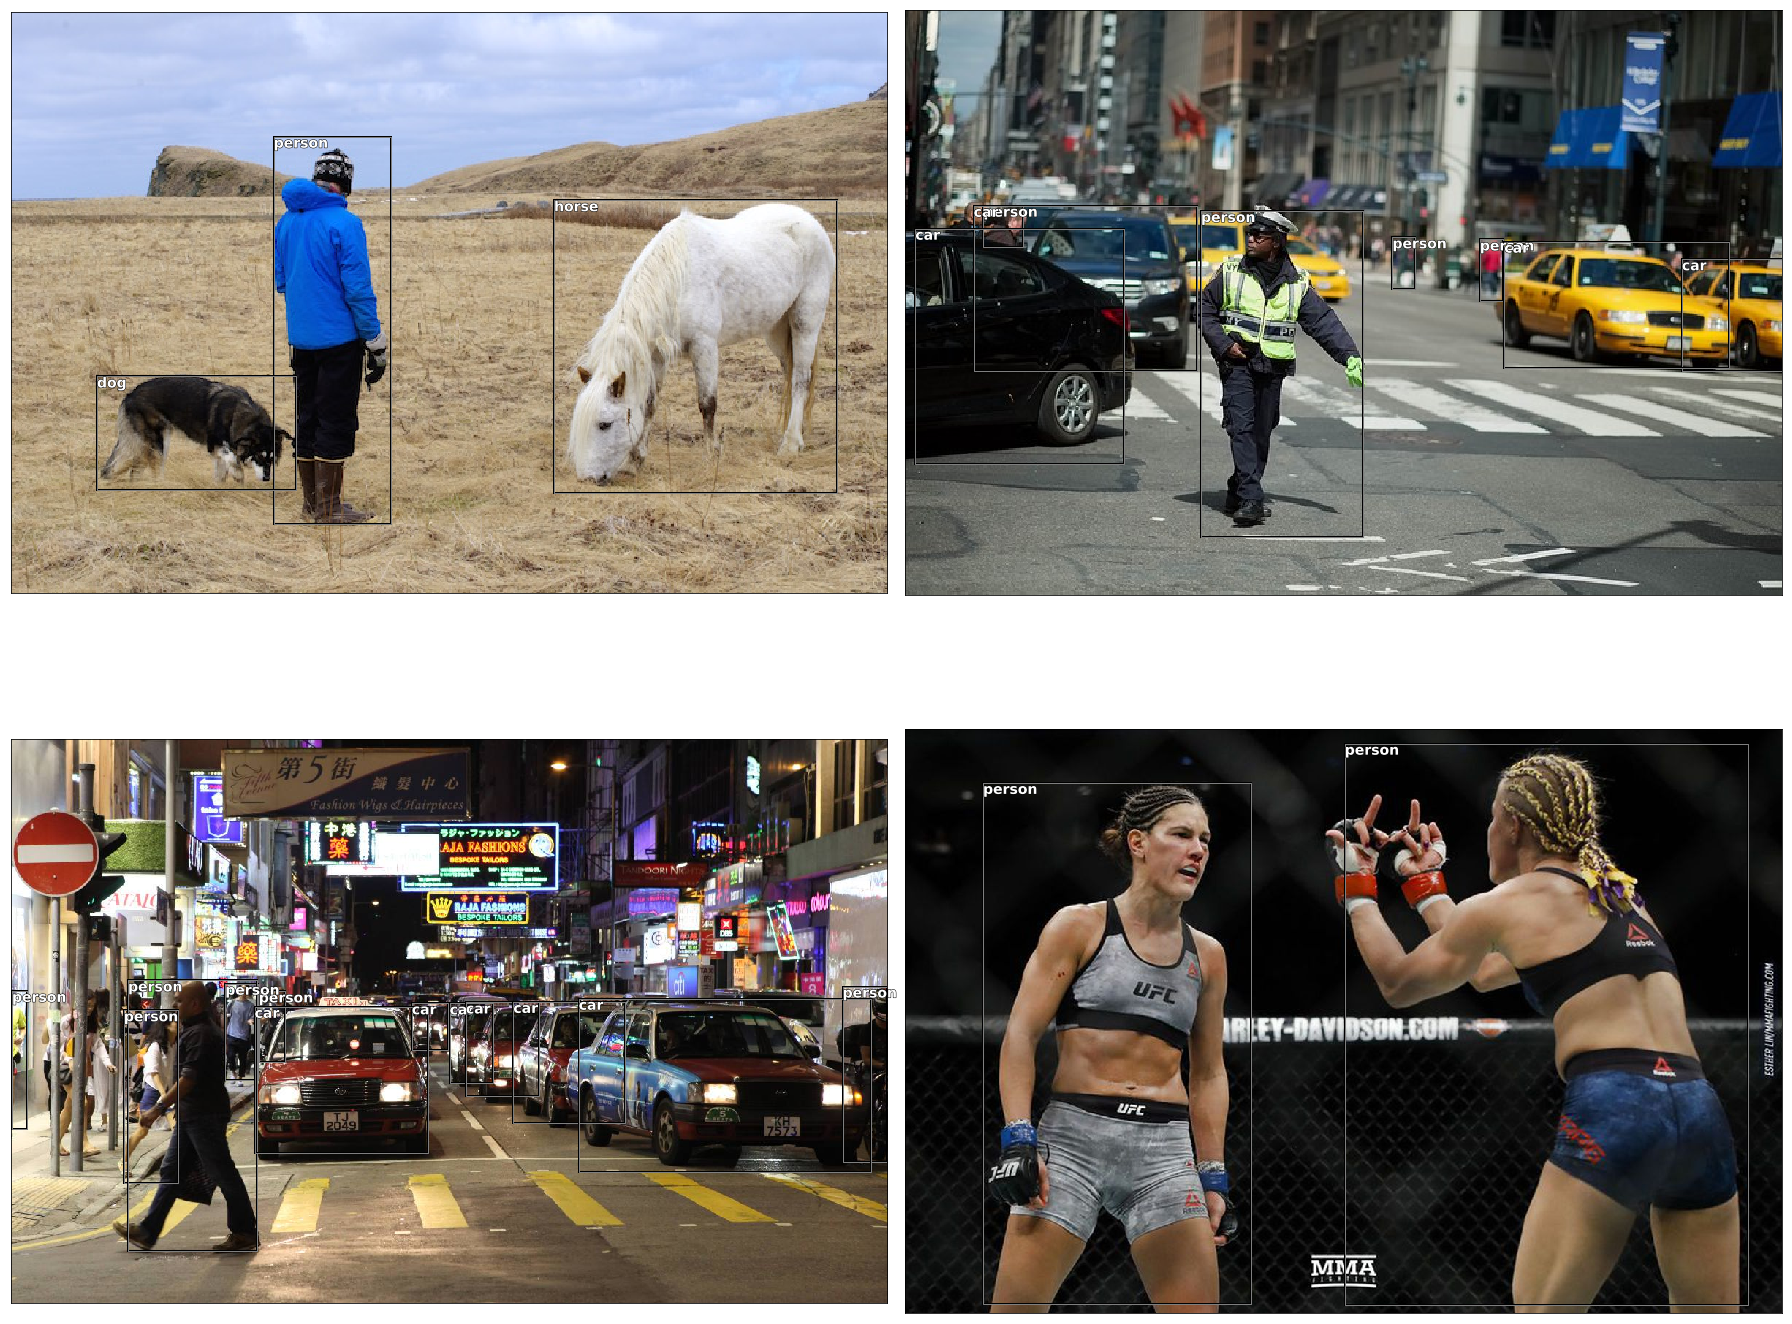

In [0]:
show_img_grid(img_list, cols=2, classes=classes, labels_list=preds_list)